In [1]:
# Imports
import string
import pandas as pd
import numpy as np
import CACConsortium_Functions as cacc
import os
import shap
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Settings
random_seed = 42
classifier_threshold = 0.5

# Model 1: Clinical characteristics + CAC
# Model 2: Clinical characteristics + CAC characteristics
toggle_model = 2

In [2]:
# Read preprocessed data
if toggle_model==1: # Model 1: Clinical characteristics + CAC
    algo_name = 'XGB_ClinVar'
    list_features_start=["index", "age", "total_score", "sex", "race_cat", "study_site", 
                  "hypertension_nonimpute", "smoker_nonimpute", "diabetes_nonimpute", 
                  "hyperlipidemia_nonimpute", "familyhistory_nonimpute"]
elif toggle_model==2: # Model 2: Clinical characterists + CAC characteristics
    algo_name = 'XGB_ClinCACVar'
    list_features_start=["index", "age", "total_score", "sex", "race_cat", "study_site", 
                  "hypertension_nonimpute", "smoker_nonimpute", "diabetes_nonimpute", 
                  "hyperlipidemia_nonimpute", "familyhistory_nonimpute", 
                  "numberofvessels", "total_volscore", "CAC_density_recalc"]
model_name = 'Vars{:02d}'.format(len(list_features_start)-1)
filename_postfix='_2020-03-17_'+model_name+'.csv'

# Read prepared data from csv 
train_data, test_data, train_data_norm, test_data_norm, train_label, test_label, feature_names, out_var \
     = cacc.load_processed_features(filename_postfix)

In [4]:
# Setup classifier training models.
model = cacc.setup_classifier_training(train_data_norm, train_label, random_seed)

# Fit the array of optimized xgboost models
model = cacc.fit_mod(train_data_norm, train_label, model, model_name, algo_name, toggle_perform_training = 1)

# Get classifier metrics
roc_auc, roc_curve_values, TP, FP, FN, TN \
    = cacc.get_roc_auc_values(model, test_data_norm, test_label, classifier_threshold)

print('AUC: {:.3f}'.format(roc_auc))

Loaded file: PKLfiles/SavedModel_Vars13_XGB_ClinCACVar_00.pkl
AUC: 0.821


In [ ]:
# Compute SHAP values for training data (may take hours)
train_dataframe = pd.DataFrame(train_data, columns = feature_names)
train_dataframe_norm = pd.DataFrame(train_data_norm, columns = feature_names)

shap.initjs()
tree_explainer = shap.TreeExplainer(model.best_estimator_, train_dataframe_norm, 
                                    feature_perturbation='interventional')
shap_values = tree_explainer.shap_values(train_dataframe_norm)
base_shap = tree_explainer.expected_value

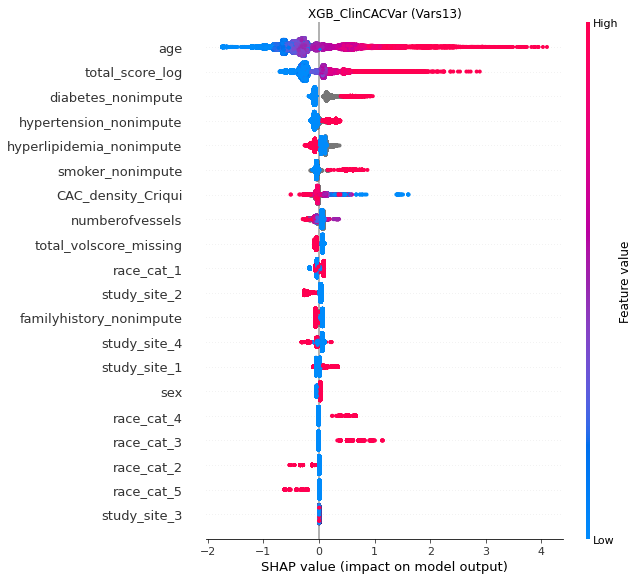

In [23]:
# Shap summary plot
plt.title('{} ({})'.format(algo_name,model_name))
shap.summary_plot(shap_values, train_dataframe_norm, feature_names=feature_names, show=False)

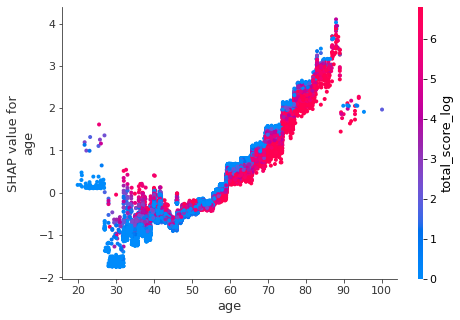

In [20]:
# Age dependence plot
shap.dependence_plot('age', shap_values, train_dataframe, interaction_index='total_score_log', 
                     feature_names=feature_names, show=False)

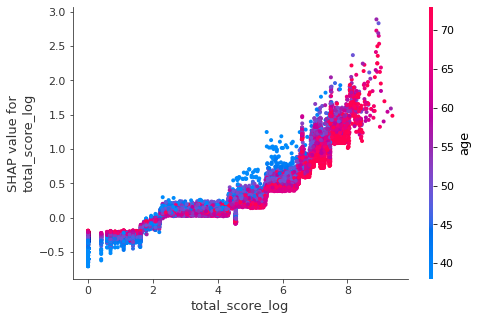

In [22]:
# Total score dependence plot
shap.dependence_plot('total_score_log', shap_values, train_dataframe, interaction_index='age', 
                     feature_names=feature_names, show=False)